In [147]:
%load_ext pycodestyle_magic
%flake8_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), l’historique des commandes détaillées et commentaires de satisfaction clients, afin de fournir aux équipes marketing une proposition de segmentation. <br/>
<br/>
Le but est de fournir une description actionnable de la segmentation et expliciter la logique sous-jacente, ainsi que les conditions de stabilité dans le temps des segments proposés (faisant l'objet d'une proposition de contrat de maintenance). <br/>
<br/>
Le présent notebook détaille l'ensemble des étapes d'analyse des données.

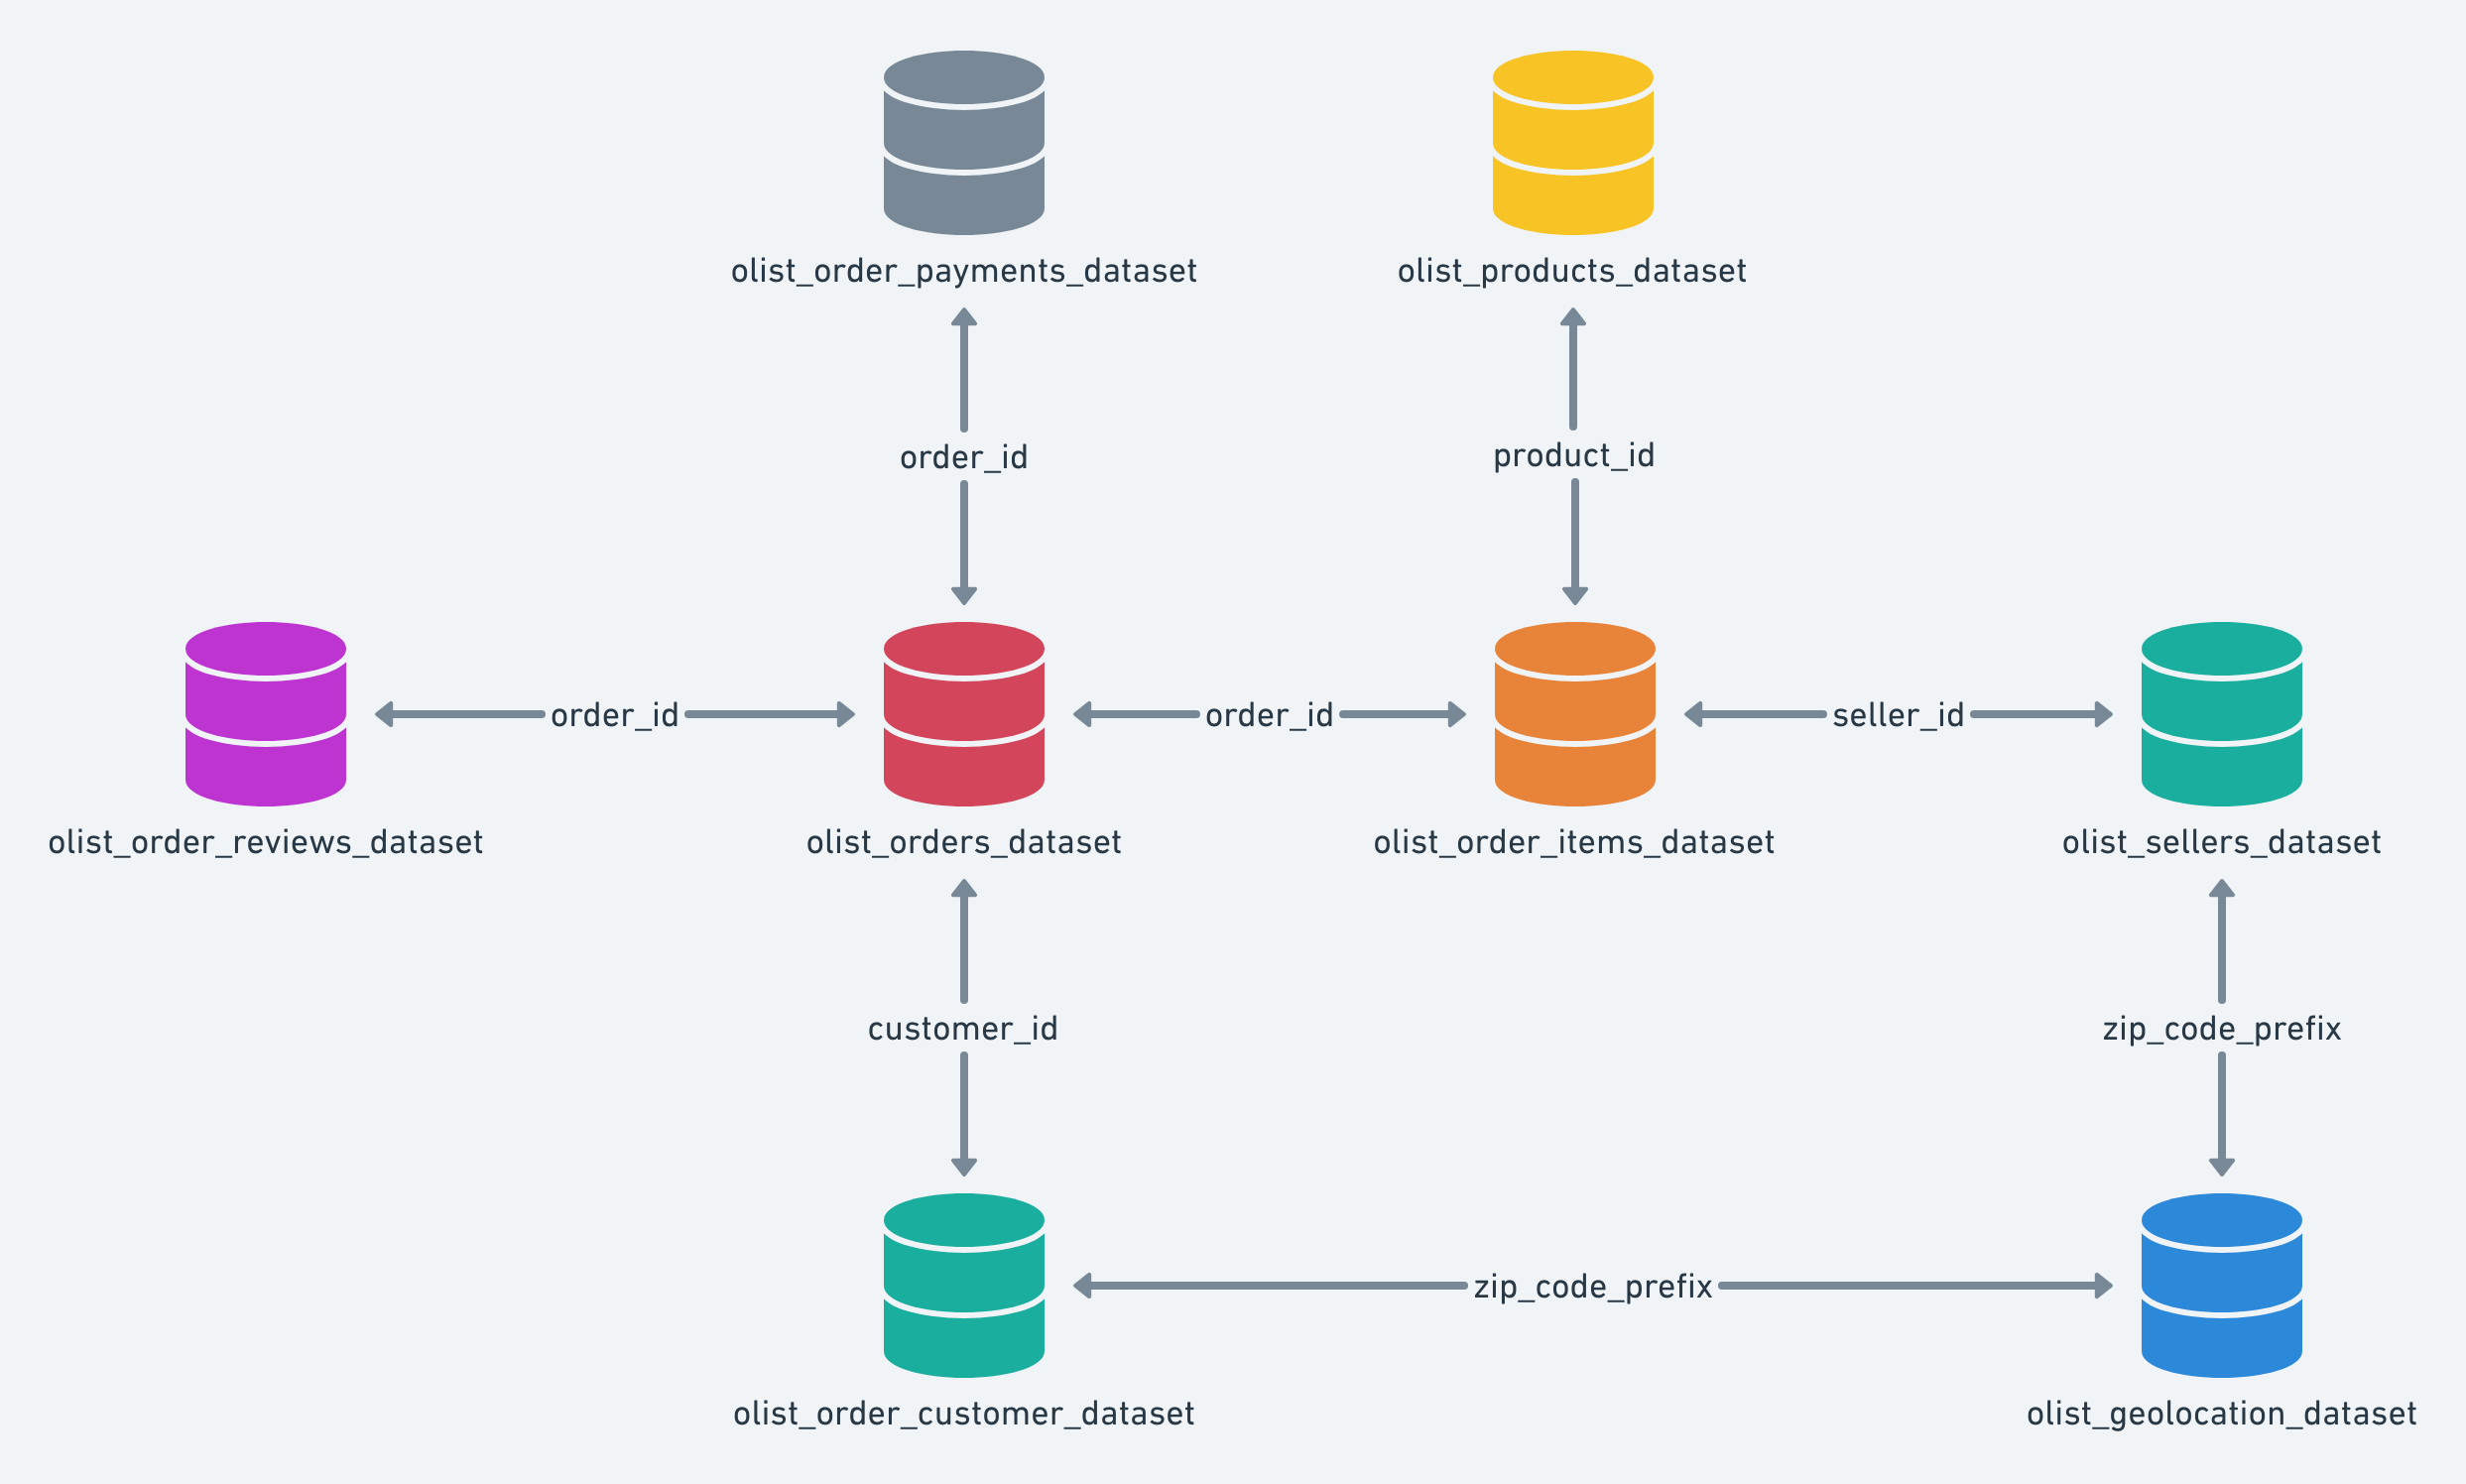

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Kaggle héberge les données et y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessuss présente les clés faisant le lien entre les datasets.<br/>
Les datasets sont fusionnables simplement, à l'exception des données de géolocalisation, qui sont associées soit aux clients, soit aux vendeurs. <br/>

Geolocation détaille toutes les paires {latitude, longitude}, associée à un zip_code_prefix, avec toute une diversité de {latitude, longitude} par {ville, état}
Pour conserver m'exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, long mean} qui sera associé à chaque ville {ville, état}.

! autant de customer_id que d'order_id, d'où l'existence d'un customerunique_id <br/>


In [203]:
# importer les packages
# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# specific
from datetime import datetime
import time

In [231]:
# créer les dataframes correspondants aux données
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [232]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [233]:
# vérifier les colonnes
for x, y in datasets.items():
    print(f'{x} : ' f'{list(y.columns)}\n')

Orders : ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Items : ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Customers : ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Payments : ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Products : ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Sellers : ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']

Reviews : ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Geolocation : ['geolo

In [234]:
# vérifier les tailles
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


### Rationnaliser les données géographiques

In [238]:
# aperçu des données geolocation
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP


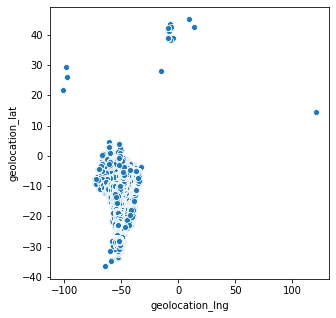

In [154]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='geolocation_lng',
                y='geolocation_lat',
                data=df_geolocation)

In [240]:
# aperçu des données géographiques pour customers
df_customers.head(7)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP


In [241]:
# aperçu des données géographiques pour customers
df_sellers.head(7)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE


In [239]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
585260,santana do paraiso,MG,25.995245,-98.078533
695377,itabatan,BA,38.323939,-6.775035
387565,bom retiro da esperanca,SP,28.008978,-15.536867
538557,santo antonio do canaa,ES,21.657547,-101.466766
769391,porto trombetas,PA,42.167251,-6.898559
727755,pau d'arco,AL,45.065933,9.341528
822529,varzea grande,MT,38.816816,-9.394625


In [156]:
# retirer les localisations hors Brésil
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [217]:
# normaliser les noms de ville
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# écrire comme "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 5965
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 609
sellers cities norm : 609


In [157]:
# simplifier par une latitude unique {ville, état}
df_geolocation['geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [158]:
# simplifier par une longitude unique {ville, état}
df_geolocation['geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [159]:
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.571253,-46.633911,sao paulo,SP
1,1046,-23.571253,-46.633911,sao paulo,SP
2,1046,-23.571253,-46.633911,sao paulo,SP
3,1041,-23.571253,-46.633911,sao paulo,SP
4,1035,-23.571253,-46.633911,sao paulo,SP
5,1012,-23.571253,-46.633911,sao paulo,SP
6,1047,-23.571253,-46.633911,sao paulo,SP
7,1013,-23.571253,-46.633911,sao paulo,SP
8,1029,-23.571253,-46.633911,sao paulo,SP
9,1011,-23.571253,-46.633911,sao paulo,SP


In [160]:
# conserver une localisation détaillée unique {city, state}
print('geoloc with {city, state} duplicates shape : '
      + str(df_geolocation.shape))
df_geolocation = df_geolocation.drop_duplicates(['geolocation_city',
                                                 'geolocation_state']).copy()
print('geoloc unique {city, state} shape : '
      + str(df_geolocation.shape))

geoloc with {city, state} duplicates shape : (1000137, 5)
geoloc unique {city, state} shape : (6345, 5)


In [161]:
# aggréger la localisation unique
df_customers = df_customers.merge(
    df_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])
df_sellers = df_sellers.merge(
    df_geolocation,
    how='left',
    left_on=['seller_city', 'seller_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [162]:
df_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state'],
      dtype='object')

In [174]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

KeyError: "['customer_zip_code_prefix' 'geolocation_zip_code_prefix'\n 'geolocation_city' 'geolocation_state'] not found in axis"

In [176]:
# réagencer les colonnes sellers
df_sellers = df_sellers.rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

In [219]:
df_sellers.sample(7)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
1581,26d6bbee02420494d471c9f6436929c0,Curitiba,PR,-25.453054,-49.274996
1662,3f9c56764fabca627406093dcb3ef0b4,Rio De Janeiro,RJ,-22.914911,-43.312877
2980,3fe7120d6257285ac6a3ce7cb071ccec,Governador Valadares,MG,-18.864178,-41.953590
2997,4ce6e5f6c52515177e18c1c9361d8677,Sao Bernardo Do Campo,SP,-23.707526,-46.563858
851,e63e8bfa530fb16910dd6956e592bb81,Guarulhos,SP,-23.446403,-46.498768
2088,c6381b1321d7d97717a5bb4ed5b77882,Sao Paulo,SP,-23.571253,-46.633911
2704,bff9deb0ec77d437f3305a79cf25529e,Limeira,SP,-22.573479,-47.408479


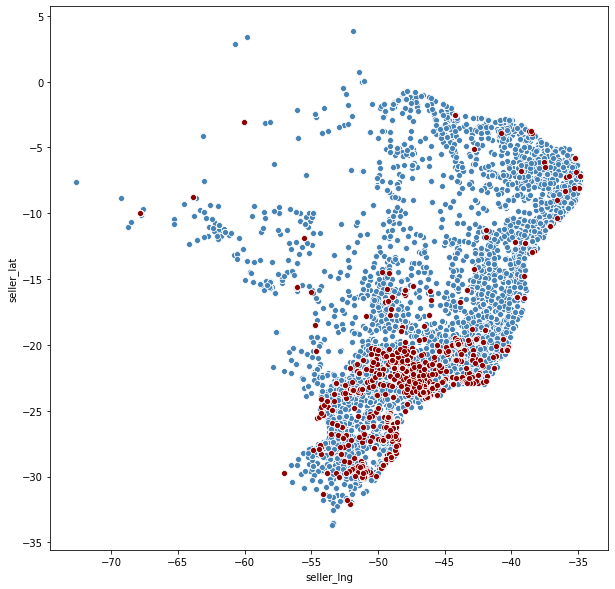

In [179]:
# affichier la répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers)
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers)


In [225]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [226]:
df_translation.sample(3)

,product_category_name,product_category_name_english
70,seguros_e_servicos,Security And Services
10,alimentos_bebidas,Food Drink
55,fashion_roupa_feminina,Fashio Female Clothing


In [227]:
df_reviews.sample(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
32855,5169fda2e6ede3e851cb4b1182352de6,8672c44699294d90098cc4ba2441d317,5,NaN,NaN,2018-06-23 00:00:00,2018-06-24 11:31:09
70641,ed7c42d41e02be9dd6165df8aa951d42,9ae55f703836fe363393a3873c1b42b4,1,NaN,estou com problemas comprei 2 antenas e só rec...,2017-03-14 00:00:00,2017-03-20 17:48:34
19103,627cac4531f301f12b42f48b225a0edb,082388d7ce9557ef064199ef978a8f3e,4,NaN,NaN,2018-08-01 00:00:00,2018-08-02 15:49:23
1739,2acd021db06be8c0c736a9392110ed95,1d14bb358f43b14725c70bdc035ce24e,5,NaN,Bom,2018-03-29 00:00:00,2018-03-31 10:29:42
65417,9784d0c77eb5e5133c1301548678d7f8,3a5ed4ec9fee02e629a8909af01459a7,4,NaN,Apesar de bem embalado o prato já veio riscado,2018-02-03 00:00:00,2018-02-04 12:23:43


In [ ]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_response_time'] = (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days
# indiquer s'il y a des commentaires
df_reviews['delivery_against_estimated'] = (df_reviews['order_estimated_delivery_date'] - df_reviews['order_delivered_customer_date']).dt.days

In [220]:
# aggréger les df (selon le modèle de données : à partir des "orders")
# via order_id pour les items, les payments et les reviews
df = pd.merge(df_orders, df_items, how='left', on='order_id')
df = pd.merge(df, df_payments, how='outer', on='order_id')
df = pd.merge(df, df_reviews, how='outer', on='order_id')
# via le customer_id pour les customers
df = pd.merge(df, df_customers, how='outer', on='customer_id')
# en rang 2 pour les items
# via le seller_id pour les sellers
df = pd.merge(df, df_sellers, how='outer', on='seller_id')
# via le product_id pour les products
df = pd.merge(df, df_products, how='outer', on='product_id')
# et enfin la tradiction du product_category_name
df = pd.merge(df, df_translation, how='outer', on='product_category_name')

In [183]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_city', 'customer_state', 'customer_lat', 'customer_lng',
       'seller_city', 'seller_state', 'seller_lat', 'seller_lng',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [221]:
df.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
35049,7f2309408220014301685cdf123b4067,5a1c1e9fe3aa6fa5a2f1d9d86f2f9aeb,delivered,2018-06-09 18:45:40,2018-06-09 19:11:02,2018-06-11 14:08:00,2018-06-14 19:31:27,2018-07-03 00:00:00,1.0,cc1cb33bcc814aeaa4631761a34bd23e,...,-50.418282,moveis_decoracao,32.0,1262.0,4.0,150.0,16.0,8.0,16.0,furniture_decor
63293,783c795ca45c01ac1ebe459d8c26751d,17d3670bca39b5c4cf9b10007975cbe3,delivered,2017-08-10 04:58:12,2017-08-10 06:43:31,2017-08-10 18:38:46,2017-08-15 17:14:55,2017-09-08 00:00:00,3.0,73258e01fadbaf7648577beb152e1320,...,-51.188582,informatica_acessorios,50.0,835.0,1.0,250.0,20.0,20.0,20.0,computers_accessories
73141,b9d5fdd84b13a6539a7a5e8851aef828,479fd4d4bc4307595d06249bfc2f70b7,delivered,2017-11-20 14:49:01,2017-11-21 04:06:56,2017-11-21 21:47:58,2017-12-05 20:47:07,2017-12-18 00:00:00,1.0,42f25a7251d847a86c1849731bf166ff,...,-51.150600,eletronicos,59.0,1413.0,2.0,450.0,16.0,16.0,11.0,electronics
31726,9f7be9e6940b2bfd52658daa8005d265,7bde890b1798d812542ac5701b228dc4,delivered,2017-08-08 11:41:18,2017-08-08 11:55:20,2017-08-09 15:30:23,2017-08-14 18:11:59,2017-08-28 00:00:00,1.0,c857b96593773e940454e76efa8eabb3,...,-48.829744,moveis_decoracao,55.0,133.0,1.0,700.0,35.0,4.0,30.0,furniture_decor
81517,b60b53ad0bb7dacacf2989fe27ad567a,2f9902d85fcd930227f711cf47012bdf,delivered,2017-05-10 14:03:27,2017-05-10 14:15:14,2017-05-11 16:25:53,2017-05-23 13:12:27,2017-05-18 00:00:00,1.0,2b80e83f77008f81ae402882631eba97,...,-46.633911,papelaria,53.0,221.0,3.0,350.0,24.0,7.0,14.0,stationery


In [146]:
df_customers['customer_state'].unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

In [145]:
df_sellers['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

In [54]:
df.shape

(119151, 40)

### Rattacher la note moyenne de chaque produit

In [197]:
# créer la note (décompte et moyenne)
df_prod_mean_score = df.groupby('product_id',
                                as_index=False).agg({'review_score': ['count',
                                                                      'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

,product_id,count,mean
22112,aca2eb7d00ea1a7b8ebd4e68314663af,536,4.009328
19742,99a4788cb24856965c36a24e339b6058,528,3.876894
8613,422879e10f46682990de24d770e7f83d,508,3.923228
7364,389d119b48cf3043d311335e499d9c6b,406,4.100985
7079,368c6c730842d78016ad823897a372db,398,3.902010
10840,53759a2ecddad2bb87a079a1f1519f73,391,3.877238
27039,d1c427060a0f73f6b889a5c7c61f2ac4,357,4.078431
10867,53b36df67ebb7c41585e8d54d6772e08,327,4.183486
2794,154e7e31ebfa092203795c972e5804a6,295,4.318644
8051,3dd2a17168ec895c781a9191c1e95ad7,278,4.183453


In [199]:
# rattacher au df via le product_id
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'count': 'review_count',
    'mean': 'review_mean'})
df = pd.merge(df, df_prod_mean_score, how='outer', on='product_id')

In [200]:
df.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_count,review_mean
10155,32e76b791f3833aebe9064d2c09dc1c5,02b9bbbd5bec26b61cfd9bd3944c2ffb,delivered,2017-11-24 15:16:05,2017-11-25 04:56:24,2017-12-15 18:29:49,2017-12-26 16:38:57,2017-12-18 00:00:00,1.0,d902e8400cd0c58b64ea157af940e670,...,52.0,786.0,2.0,3800.0,44.0,23.0,43.0,baby,9.0,3.888889
61803,be3b8d058b8100d8a2539ce0b2c6ec0b,2cb9cd4d83c7018f46ff002953f95901,canceled,2017-07-20 14:32:34,2017-07-20 14:45:19,NaN,NaN,2017-08-11 00:00:00,1.0,20332c1e41e427864b3561a657caaf0d,...,59.0,916.0,1.0,700.0,16.0,12.0,12.0,watches_gifts,3.0,4.000000
71489,5e32d63948bae10a5a878d024e3e4e37,99b81369c2f7870fee6166d01c7a5e02,delivered,2018-03-15 12:23:11,2018-03-15 12:35:22,2018-03-16 17:03:01,2018-03-18 15:42:24,2018-03-27 00:00:00,1.0,c3097e07a0a5de0d4b4c836d90c5a284,...,43.0,425.0,1.0,200.0,22.0,11.0,16.0,electronics,31.0,4.032258
98458,4bf603cde1e3f217c4f534a43c79f36a,3745f821304d2d872da468c124e48b3e,delivered,2018-01-28 12:23:34,2018-01-28 12:40:04,2018-01-30 13:06:38,2018-02-06 17:12:14,2018-02-23 00:00:00,1.0,f6fa93875f4a7dac03e0a22143f4d815,...,37.0,212.0,2.0,450.0,25.0,9.0,19.0,bed_bath_table,25.0,4.240000
52856,866968d6a38b907a312ffddbe6287d8e,963aad8750ffca2b194092e8d0dc5aaf,delivered,2017-04-15 09:41:35,2017-04-15 09:55:09,2017-04-18 15:09:26,2017-04-20 14:33:48,2017-05-08 00:00:00,1.0,8283442d1af5a158404e8f4cb53a2090,...,39.0,344.0,1.0,700.0,21.0,9.0,12.0,auto,1.0,5.000000


In [201]:
df.order_status.unique()

array(['delivered', 'shipped', 'canceled', 'invoiced', 'processing',
       'approved', 'unavailable', 'created'], dtype=object)

### Données temporelles

In [206]:
# formater toutes les colonnes dates
date_columns = ['shipping_limit_date',
                'review_creation_date',
                'review_answer_timestamp',
                'order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [212]:
# décomposer en année, mois, jour, heure et spécifier les jours et les mois
df['order_purchase_year'] = \
    df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = \
    df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = \
    df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = \
    df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = \
    df['order_purchase_dayofweek'].map({0: 'Mon',
                                        1: 'Tue',
                                        2: 'Wed',
                                        3: 'Thu',
                                        4: 'Fri',
                                        5: 'Sat',
                                        6: 'Sun'})
df['order_purchase_month'] = \
    df.order_purchase_timestamp.apply(lambda x: x.month).map({0: 'Jan',
                                                              1: 'Feb',
                                                              2: 'Mar',
                                                              3: 'Apr',
                                                              4: 'May',
                                                              5: 'Jun',
                                                              6: 'Jul',
                                                              7: 'Aug',
                                                              8: 'Sep',
                                                              9: 'Oct',
                                                              10: 'Nov',
                                                              11: 'Dec'})

In [213]:
df.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_width_cm,product_category_name_english,review_count,review_mean,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon
30840,07d35f516238db3cf2e71da57744922d,6b9c954ac26835161d0f34df89ca1175,delivered,2018-02-04 12:11:39,2018-02-04 12:31:42,2018-02-15 22:58:58,2018-02-21 18:29:17,2018-03-01,2.0,43ee88561093499d9e571d4db5f20b79,...,20.0,furniture_decor,20.0,2.550000,2018,Mar,6,12,Sun,Mar
38759,88131f6562db887981cc8ab363deb03f,0d05af7e5a21aa81bdc60f6cb6ae91cf,delivered,2018-05-18 14:14:07,2018-05-18 14:34:53,2018-05-21 15:02:00,2018-05-23 20:24:37,2018-06-13,1.0,58f63077f5153309a576fda4e0851982,...,17.0,perfumery,6.0,5.000000,2018,Jun,4,14,Fri,Jun
41455,423a4ec1579258ccf1267d7414246c52,1388eca3c7f75f6038c0d636f9f3b2ca,delivered,2017-06-06 23:09:15,2017-06-07 14:25:22,2017-06-09 09:21:33,2017-06-19 19:58:28,2017-07-03,1.0,b1acb7e8152c90c9619897753a75c973,...,15.0,health_beauty,50.0,4.200000,2017,Jul,1,23,Tue,Jul
92783,b73183cb490ec16839818660ffc3d832,9c6bf855fea8ceee89c3a2f9073e65de,delivered,2018-05-14 11:01:01,2018-05-14 11:15:27,2018-05-16 15:50:00,2018-05-23 18:38:18,2018-06-06,1.0,1fb344134cd7164d32dea4d87ba3ec5a,...,20.0,garden_tools,17.0,4.235294,2018,Jun,0,11,Mon,Jun
51730,6d34c087b843ae0fdb296f15d948e45f,8d00bb042dfdfc4c8121bcd01fbc78bc,delivered,2018-06-20 19:11:56,2018-06-20 19:39:40,2018-06-26 13:17:00,2018-06-29 17:21:38,2018-07-17,1.0,4b5d91666a29ed91f1ced25011e07985,...,50.0,pet_shop,8.0,5.000000,2018,Jul,2,19,Wed,Jul
